# Using Unsupervised Learning to perform fraud detection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
X = df.drop('Class', axis=1)
y = df['Class']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2018, stratify=y)

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [6]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.485354,0.616432,0.005438,0.100842,-0.040599,-0.156945,-0.347820,0.048454,-0.051776,-0.076094,...,-0.093993,0.014280,0.314554,-0.084434,0.565019,0.844320,2.326252,-0.192003,-0.054478,-0.344209
1,0.383641,1.061403,0.001659,-0.956874,0.123748,0.175600,-0.676766,0.154914,-0.258849,0.628875,...,-0.258020,0.356135,1.292187,0.007174,1.267814,0.706925,-0.940749,0.014314,-0.137846,-0.347428
2,-0.749872,-0.526574,0.597088,0.601318,-0.140631,0.207599,-0.084460,0.286180,0.216273,-0.014437,...,-0.034645,-0.353186,-0.923367,0.216800,-0.678644,-0.408185,0.209263,0.340158,0.307621,-0.326645
3,-0.823921,0.051772,0.379046,0.383246,0.150966,0.531842,0.410562,0.203407,0.183785,-0.508859,...,0.048436,-0.074398,-0.186814,0.246773,-1.910209,-2.803522,0.184902,0.601053,0.671161,-0.340712
4,0.522640,1.114019,-0.560317,-1.914568,-1.432293,1.474020,2.223305,-0.596768,0.531852,-0.778405,...,0.091871,0.076503,-0.049299,0.377269,1.157875,-0.065916,-0.611448,-0.079773,-0.195874,-0.232390


# PCA

In [7]:
# dimentionality reduction algorithm is trying to reconstruct and minimize the reconstruction error
# since fraud are very rare in terms of occurence 
# and presumably different than normal transactions,
# the fraudulent transactions should exhibit the largest reconstruction error

from sklearn.decomposition import PCA
pca = PCA(n_components=30, whiten=False, random_state=2018)

In [8]:
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index)

In [9]:
X_train_pca_inverse = pca.inverse_transform(X_train_pca)
X_train_pca_inverse = pd.DataFrame(X_train_pca_inverse, index=X_train_pca.index)

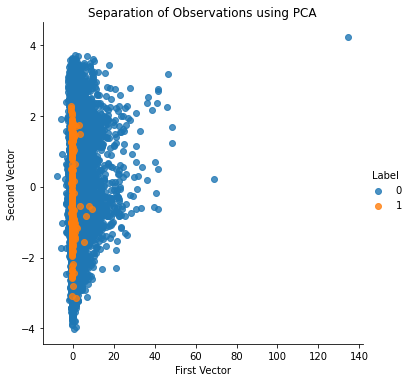

In [11]:
# View scatterplot
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

scatterPlot(X_train_pca, y_train, "PCA")

In [12]:
loss = pd.Series(np.sum((np.array(X_train_pca_inverse) - np.array(X_train))**2, axis=1))
anomalyScore = (loss - loss.min())/(loss.max() - loss.min())

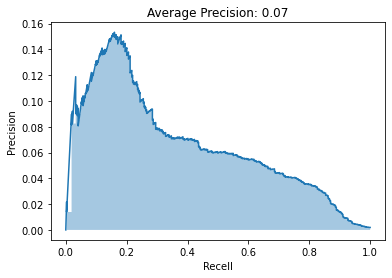

Area Under Curve: 0.07


In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
precision, recall, thresholds = precision_recall_curve(y_train, anomalyScore)
plt.plot(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)))
plt.fill_between(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)), step="pre", alpha=0.4)
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.title(f'Average Precision: {round(average_precision_score(y_train, anomalyScore), 2)}')
plt.show()

area_under_curve = auc(x=recall, y=precision)
print(f'Area Under Curve: {round(area_under_curve, 2)}')

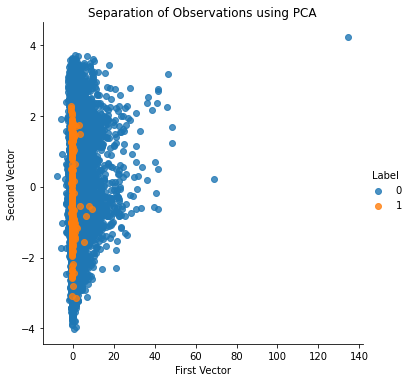

In [14]:
pca = PCA(n_components=27, whiten=False, random_state=2018)
X_train_pca = pca.fit_transform(X_train)
X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index)
X_train_pca_inverse = pca.inverse_transform(X_train_pca)
X_train_pca_inverse = pd.DataFrame(X_train_pca_inverse, index=X_train_pca.index)

scatterPlot(X_train_pca, y_train, "PCA")

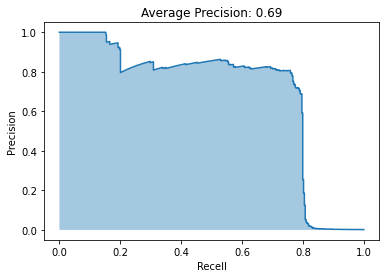

In [15]:
loss = pd.Series(np.sum((np.array(X_train_pca_inverse) - np.array(X_train))**2, axis=1))
anomalyScore = (loss - loss.min())/(loss.max() - loss.min())

precision, recall, thresholds = precision_recall_curve(y_train, anomalyScore)
plt.plot(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)))
plt.fill_between(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)), step="pre", alpha=0.4)
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.title(f'Average Precision: {round(average_precision_score(y_train, anomalyScore), 2)}')
plt.show()

# Dictionary Learning

In [16]:
from sklearn.decomposition import MiniBatchDictionaryLearning
mnbdl = MiniBatchDictionaryLearning(n_components=28, alpha=1, batch_size=200, n_iter=10, random_state=2018)

In [23]:
X_train_mnbdl = pd.DataFrame(mnbdl.fit_transform(X_train), index=X_train.index)
X_train_mnbdl_inverse = pd.DataFrame(np.array(X_train_mnbdl).dot(mnbdl.components_), index=X_train.index)

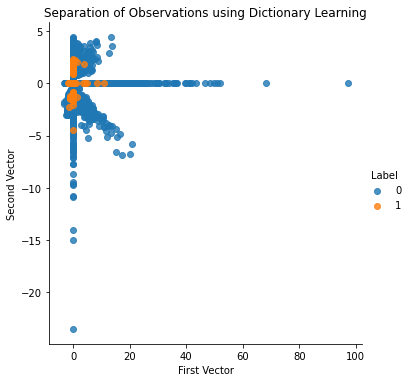

In [24]:
scatterPlot(X_train_mnbdl, y_train, "Dictionary Learning")

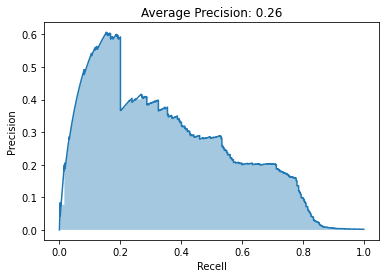

In [25]:
loss = pd.Series(np.sum((np.array(X_train_mnbdl_inverse) - np.array(X_train))**2, axis=1))
anomalyScore = (loss - loss.min())/(loss.max() - loss.min())

precision, recall, thresholds = precision_recall_curve(y_train, anomalyScore)
plt.plot(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)))
plt.fill_between(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)), step="pre", alpha=0.4)
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.title(f'Average Precision: {round(average_precision_score(y_train, anomalyScore), 2)}')
plt.show()

# Apply the algorithm on testset

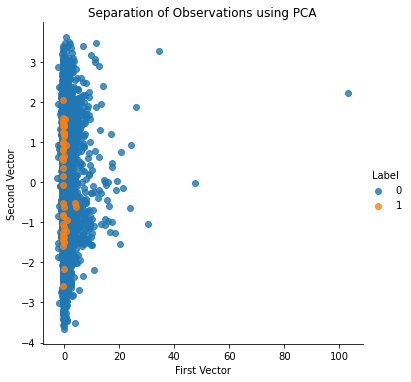

In [30]:
pca = PCA(n_components=27, whiten=False, random_state=2018)
pca.fit(X_train)

X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame(X_test_pca, index=X_test.index)
X_test_pca_inverse = pca.inverse_transform(X_test_pca)
X_test_pca_inverse = pd.DataFrame(X_test_pca_inverse, index=X_test_pca.index)

scatterPlot(X_test_pca, y_test, "PCA")

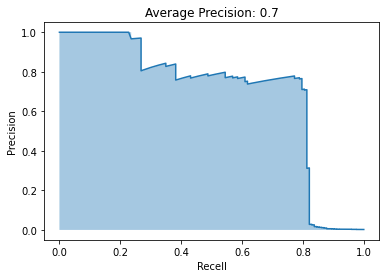

In [31]:
loss = pd.Series(np.sum((np.array(X_test_pca_inverse) - np.array(X_test))**2, axis=1))
anomalyScore = (loss - loss.min())/(loss.max() - loss.min())

precision, recall, thresholds = precision_recall_curve(y_test, anomalyScore)
plt.plot(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)))
plt.fill_between(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)), step="pre", alpha=0.4)
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.title(f'Average Precision: {round(average_precision_score(y_test, anomalyScore), 2)}')
plt.show()

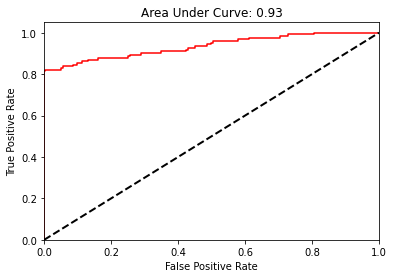

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, anomalyScore)

from sklearn.metrics import auc
plt.plot(fpr, tpr, color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.title(f'Area Under Curve: {round(auc(fpr, tpr), 2)}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [48]:
mnbdl = MiniBatchDictionaryLearning(n_components=28, alpha=1, batch_size=200, n_iter=10, random_state=2018)

In [49]:
mnbdl.fit(X_train)

MiniBatchDictionaryLearning(batch_size=200, n_components=28, n_iter=10,
                            random_state=2018)

In [50]:
X_test_mnbdl = pd.DataFrame(mnbdl.transform(X_test), index=X_test.index)

In [51]:
X_test_mnbdl_inverse = pd.DataFrame(np.array(X_test_mnbdl).dot(mnbdl.components_), index=X_test.index)

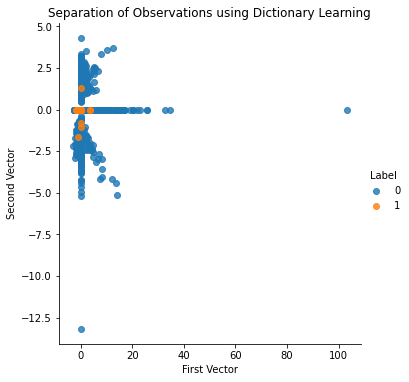

In [52]:
scatterPlot(X_test_mnbdl, y_test, "Dictionary Learning")

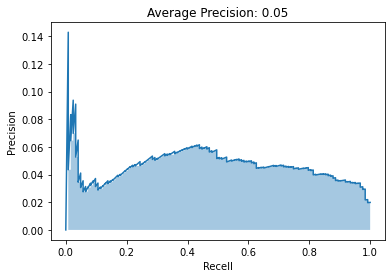

In [79]:
loss = pd.Series(np.sum((np.array(X_test_mnbdl) - np.array(y_test).reshape(71202, -1))**2, axis=1))
anomalyScore = (loss - loss.min())/(loss.max() - loss.min())

precision, recall, thresholds = precision_recall_curve(y_test, anomalyScore)
plt.plot(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)))
plt.fill_between(np.delete(recall, np.argmax(precision)), np.delete(precision, np.argmax(precision)), step="pre", alpha=0.4)
plt.xlabel('Recell')
plt.ylabel('Precision')
plt.title(f'Average Precision: {round(average_precision_score(y_test, anomalyScore), 2)}')
plt.show()

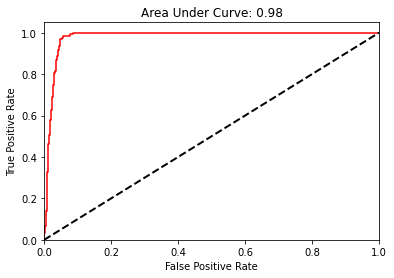

In [80]:
fpr, tpr, thresholds = roc_curve(y_test, anomalyScore)

plt.plot(fpr, tpr, color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.title(f'Area Under Curve: {round(auc(fpr, tpr), 2)}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()